# Unsupervised Anomaly Detection on fastMRI

### *Run these cells only when in Google Colab*

In [71]:
# # Clone the repository
# !git clone https://github.com/compai-lab/mad_seminar_s23.git
# # Move all content to the current directory
# !mv ./mad_seminar_s23/* ./
# # Remove the empty directory
# !rm -rf mad_seminar_s23/

In [72]:
# # Download the data
# !wget <link you got from your supervisor>
# # Extract the data
# !unzip -q ./data.zip

In [73]:
# # Install additional packages
# !pip install pytorch_lightning --quiet
# !pip install lpips

## Imports

In [74]:
import matplotlib.pyplot as plt
import pytorch_lightning as pl
import torch
import yaml
import contextlib
import logging
import os
import numpy as np
import torch
import model.patchcore.backbones
import model.patchcore.common
import model.patchcore.metrics
import model.patchcore.patchcore
import model.patchcore.sampler
import model.patchcore.utils

from data_loader import TrainDataModule, get_all_test_dataloaders, get_test_dataloader
from model.patchcore.run_patchcore import dataset, run, patch_core, sampler
from model.patchcore.patchcore import PatchCore
from data_loader import TrainDataModule, get_all_test_dataloaders

# autoreload imported modules
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load the config

In [75]:
with open('./configs/autoencoder_config.yaml', 'r') as f:
    config = yaml.safe_load(f)

# Reproducibility
pl.seed_everything(config['seed'])

Global seed set to 42


42

## Load and visualize the data

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(128, 128)
Using 711 IXI images and 130 fastMRI images for training. Using 15 images for validation.
Batch shape: torch.Size([1, 3, 128, 128])
Batch min: -2.1179039478302
Batch max: 2.640000104904175


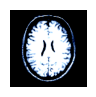

In [81]:
train_data_module = TrainDataModule(
    split_dir=config['split_dir'],
    target_size=config['target_size'],
    batch_size=config['batch_size'])

test_dataloaders = get_all_test_dataloaders(config['split_dir'], config['target_size'], config['batch_size'])

# Plot some images
batch = next(iter(train_data_module.train_dataloader()))

# Print statistics
print(f"Batch shape: {batch.shape}")
print(f"Batch min: {batch.min()}")
print(f"Batch max: {batch.max()}")

img_num = min(5, batch.shape[0])

fig, ax = plt.subplots(1, img_num, figsize=(15, img_num))
if (img_num)>1:
    for i in range(img_num):
        ax[i].imshow(batch[i].squeeze().permute(1,2,0))
        ax[i].axis('off')
else:
    ax.imshow(batch[i].squeeze().permute(1,2,0))
    ax.axis('off')
plt.show()

## Prepare Parameters

In [84]:
# we run the patchcore model

methods ={}
methods["get_dataloaders"] = {"training": train_data_module,
            "validation": train_data_module,
            "testing": test_dataloaders, 
            "names": [
        'absent_septum',
        'artefacts',
        'craniatomy',
        'dural',
        'ea_mass',
        'edema',
        'encephalomalacia',
        'enlarged_ventricles',
        'intraventricular',
        'lesions',
        'mass',
        'posttreatment',
        'resection',
        'sinus',
        'wml',
        'other'
    ]}

n1, f1 = sampler('approx_greedy_coreset', 0.1 )
methods[n1] =f1
# we also pick greedy_coreset because that is what PNI paper mentions
# 0.1 is the default value according to documentation
n2, f2 =patch_core(["vgg19"], ['features.2', 'features.4'], 128, 128, "mean", "mean", 5, 3, "max", 0.0, [], True, 8)
methods[n2] = f2
# rest of values are just default 


results_path = r"D:\D_Coding\Coding\PNI_Medical_Anomaly\results"
# make sure gpus is correctly used
gpu = [0]
seed = config["seed"]
log_group = "group"
log_project = "project"
save_segmentation_images = True
save_patchcore_model = False

neighborhood_info = False
position_info = False
refinement = False

## Run training

In [85]:
LOGGER = logging.getLogger(__name__)

_DATASETS = {"mri_images": ["PNI_Medical_Anomaly.data_loader", "TrainDataset"], }


run_save_path = model.patchcore.utils.create_storage_folder(
    results_path, log_project, log_group, mode="iterate"
)

dataloaders = methods["get_dataloaders"]

device = model.patchcore.utils.set_torch_device(gpu)
# Device context here is specifically set and used later
# because there was GPU memory-bleeding which I could only fix with
# context managers.
device_context = (
    torch.cuda.device("cuda:{}".format(device.index))
    if "cuda" in device.type.lower()
    else contextlib.suppress()
)

result_collect = []

model.patchcore.utils.fix_seeds(seed, device)

dataset_name = dataloaders["training"].name
print("sanity check")
print("name: " + dataset_name)

with device_context:
    torch.cuda.empty_cache()
    imagesize = dataloaders["training"].input_size
    sampler = methods["get_sampler"](
        device,
    )
    PatchCore_list = methods["get_patchcore"](imagesize, sampler, device)
    if len(PatchCore_list) > 1:
        LOGGER.info(
            "Utilizing PatchCore Ensemble (N={}).".format(len(PatchCore_list))
        )
    for i, PatchCore in enumerate(PatchCore_list):
        torch.cuda.empty_cache()
        if PatchCore.backbone.seed is not None:
            model.patchcore.utils.fix_seeds(PatchCore.backbone.seed, device)
        LOGGER.info(
            "Training models ({}/{})".format(i + 1, len(PatchCore_list))
        )
        torch.cuda.empty_cache()
        PatchCore.fit(dataloaders["training"].train_dataloader())

sanity check
name: training mri images


C:\Users\asnra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\asnra\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to C:\Users\asnra/.cache\torch\hub\checkpoints\vgg19-dcbb9e9d.pth
100%|█████████▉| 548M/548M [15:40<00:00, 1.21MB/s

## Evaluation

In [ ]:
# Reconstructions from the validation set
with device_context:
    torch.cuda.empty_cache()
    aggregator = {"pathologies": [], "scores": [], "segmentations": []}
    for i, PatchCore in enumerate(PatchCore_list):
        torch.cuda.empty_cache()
        LOGGER.info(
            "Embedding test data with models ({}/{})".format(
                i + 1, len(PatchCore_list)
            )
        )
        for name in methods["get_dataloaders"]["names"]:
            scores, segmentations, labels_gt, masks_gt = PatchCore.predict(
                dataloaders["testing"][name]
            )
            aggregator["pathologies"].append(name)
            aggregator["scores"].append(scores)
            aggregator["segmentations"].append(segmentations)

In [ ]:
from evaluate import Evaluator 

evaluator = Evaluator(PatchCore, torch.device('cuda'), test_dataloaders)

metrics, fig_metrics, fig_example = evaluator.evaluate()

In [ ]:
fig_example

In [ ]:
fig_metrics['F1']